In [1]:
# Install and import tools that will allow us to download our data
%pip install wget
%pip install gcsfs
import requests
import gcsfs
from google.cloud import storage       # No install required

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=7f115ed9f85a734331cd61f8d145f2a3dd484abfc15e19afca1e6b8f1f9eae82
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Get our download links and the name of the bucket we will save to

In [6]:
# Before starting, we need a bucket you want to save to.
# This script will assume the bucket has a landing folder
bucket_name = "ppp-loans-bucket"

In [3]:
# Urls to download PPP loan data
ppp_url_0 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/c1275a03-c25c-488a-bd95-403c4b2fa036/download/public_150k_plus_240930.csv"
ppp_url_1 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/cff06664-1f75-4969-ab3d-6fa7d6b4c41e/download/public_up_to_150k_1_240930.csv"
ppp_url_2 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/1e6b6629-a5aa-46e6-a442-6e67366d2362/download/public_up_to_150k_2_240930.csv"
ppp_url_3 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/644c304a-f5ad-4cfa-b128-fe2cbcb7b26e/download/public_up_to_150k_3_240930.csv"
ppp_url_4 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/98af633d-eb1b-4d4b-995d-330962e6c38d/download/public_up_to_150k_4_240930.csv"
ppp_url_5 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/3b407e04-f269-47a0-a5fe-661d1a08a76c/download/public_up_to_150k_5_240930.csv"
ppp_url_6 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/7b7b5b58-9645-4b88-a675-a8a825e77076/download/public_up_to_150k_6_240930.csv"
ppp_url_7 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/dabdddb5-1807-44f6-97c6-d624a5372525/download/public_up_to_150k_7_240930.csv"
ppp_url_8 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/1fc6ddc4-ccb0-49d4-b632-0749e3292e57/download/public_up_to_150k_8_240930.csv"
ppp_url_9 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/e9f2c718-b95e-47da-8f3e-17154aab1c86/download/public_up_to_150k_9_240930.csv"
ppp_url_10 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/d9972f0d-c377-46ac-8637-a5c1265377c8/download/public_up_to_150k_10_240930.csv"
ppp_url_11 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/8db19ddc-f036-40df-89f9-d0d309aa58b5/download/public_up_to_150k_11_240930.csv"
ppp_url_12 = "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/7e4f672f-d163-4735-a5ec-f23afa2835db/download/public_up_to_150k_12_240930.csv"

ppp_urls = [ppp_url_0, ppp_url_1, ppp_url_2, 
            ppp_url_3, ppp_url_4, ppp_url_5,
            ppp_url_6, ppp_url_7, ppp_url_8, ppp_url_9,
            ppp_url_10, ppp_url_11, ppp_url_12]


In [4]:
# Url to download GDP data
gdp_url = "put url here"

In [4]:
# Url to download NAICS data
naics_url = "https://www.census.gov/naics/2022NAICS/2-6%20digit_2022_Codes.xlsx"

# Create a download function that can be used for all our download processes

In [8]:
# This function will accept a url to download a file, and a name for that file be to named once downloaded.
# The file will be downloaded to the landing folder in the ppp-loans-bucket bucket.
def download(url: str, file_name: str):
    
    #Small if-elif tree to append the file type to the end of the name. Type is determined by the url inputted.
    file_type = ""
    if url[-3:] == "csv":
        file_type = ".csv"
    elif url[-4:] == "xlsx":
        file_type = ".xlsx"
    
    #This will make sure, if a type is detected, that it will download the file as that type instead of being typeless
    file_name = file_name + file_type
    
    
    # GCS bucket and folder
    folder_name = "landing"  # Specific folder within the bucket
    
    # Step 1: Download the file locally
    response = requests.get(url)
    response.raise_for_status()

    local_file = file_name
    with open(local_file, "wb") as file:
        file.write(response.content)

    print(f"File {local_file} downloaded locally. Beginning upload to Bucket["+str(bucket_name)+"]")

    # Step 2: Initialize GCS client
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    
    # Step 3: Define the full path in the bucket
    blob = bucket.blob(f"{folder_name}/{file_name}")

    # Check if the file already exists in GCS and delete it (optional, for clarity)
    if blob.exists():
        print(f"File {file_name} already exists. Deleting it...")
        blob.delete()
    
    # Step 4: Upload the file to GCS
    blob.upload_from_filename(local_file)

    print(f"File uploaded to gs://{bucket_name}/{folder_name}/{file_name}")

# Download PPP data

In [7]:
# Simple for loop to download all PPP csv files.
for index in range(len(ppp_urls)):
    # Download using the url at the index, and label all the files. (So from 0-12)
    download(ppp_urls[index],"ppp_loans["+str(index)+"]")

File ppp_loans[0].csv already exists. Deleting it...
File uploaded to gs://ppp-loans-bucket/landing/ppp_loans[0].csv
File ppp_loans[1].csv already exists. Deleting it...
File uploaded to gs://ppp-loans-bucket/landing/ppp_loans[1].csv
File ppp_loans[2].csv already exists. Deleting it...
File uploaded to gs://ppp-loans-bucket/landing/ppp_loans[2].csv
File ppp_loans[3].csv already exists. Deleting it...
File uploaded to gs://ppp-loans-bucket/landing/ppp_loans[3].csv
File ppp_loans[4].csv already exists. Deleting it...
File uploaded to gs://ppp-loans-bucket/landing/ppp_loans[4].csv
File ppp_loans[5].csv already exists. Deleting it...
File uploaded to gs://ppp-loans-bucket/landing/ppp_loans[5].csv
File ppp_loans[6].csv already exists. Deleting it...
File uploaded to gs://ppp-loans-bucket/landing/ppp_loans[6].csv
File ppp_loans[7].csv already exists. Deleting it...
File uploaded to gs://ppp-loans-bucket/landing/ppp_loans[7].csv
File ppp_loans[8].csv already exists. Deleting it...
File upload

# Download NAICS Data

In [9]:
# Download NAICS data
download(naics_url, "NAICS_2-6-digit_2022_Codes")

File NAICS_2-6-digit_2022_Codes.xlsx downloaded locally. Beginning upload to Bucket[ppp-loans-bucket]
File uploaded to gs://ppp-loans-bucket/landing/NAICS_2-6-digit_2022_Codes.xlsx


In [9]:
# Download GDP data - (NOTE: GDP HAS BEEN GIVEN TO US AND WILL NOT BE DOWNLOADED FROM A URL)
#download(gdp_url, "")

# Listing files in our bucket to make sure we downloaded everything

In [10]:
# List the contents of the bucket to see if everything downloadedlanding/ppp_loans[0]
client = storage.Client()
bucket = client.get_bucket(bucket_name)

# List all blobs in the bucket
blobs = bucket.list_blobs()

print("Files in bucket:")
for blob in blobs:
    print(blob.name)

Files in bucket:
cleaned/
cleaned/GDP.csv
cleaned/NAICS.csv
cleaned/_SUCCESS
cleaned/part-00000-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/part-00001-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/part-00002-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/part-00003-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/part-00004-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/part-00005-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/part-00006-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/part-00007-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/part-00008-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/part-00009-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/part-00010-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/part-00011-a9f58663-6a3c-4608-b6a1-dd50d907243e-c000.snappy.parquet
cleaned/par

# Small Exploratory Data Analysis on the PPP Loans

In [38]:
import pandas as pd

fs = gcsfs.GCSFileSystem(project='cis4400-group-project')
with fs.open('ppp-loans-bucket/landing/ppp_loans[0].csv') as f:
    df = pd.read_csv(f, encoding='latin1')
df.head()

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,BusinessType,OriginatingLenderLocationID,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,ForgivenessAmount,ForgivenessDate
0,9547507704,05/01/2020,464,PPP,"SUMTER COATINGS, INC.",2410 Highway 15 South,Sumter,NaN,29150-9662,12/18/2020,...,Corporation,19248,Synovus Bank,COLUMBUS,GA,Unanswered,Unanswered,NaN,773553.37,11/20/2020
1,9777677704,05/01/2020,464,PPP,"PLEASANT PLACES, INC.",7684 Southrail Road,North Charleston,NaN,29420-9000,09/28/2021,...,Sole Proprietorship,19248,Synovus Bank,COLUMBUS,GA,Male Owned,Non-Veteran,NaN,746336.24,08/12/2021
2,5791407702,05/01/2020,1013,PPP,BOYER CHILDREN'S CLINIC,1850 BOYER AVE E,SEATTLE,NaN,98112-2922,03/17/2021,...,Non-Profit Organization,9551,"Bank of America, National Association",CHARLOTTE,NC,Unanswered,Unanswered,Y,696677.49,02/10/2021
3,6223567700,05/01/2020,920,PPP,KIRTLEY CONSTRUCTION INC,1661 MARTIN RANCH RD,SAN BERNARDINO,NaN,92407-1740,10/16/2021,...,Corporation,9551,"Bank of America, National Association",CHARLOTTE,NC,Female Owned,Non-Veteran,NaN,395264.11,09/10/2021
4,9662437702,05/01/2020,101,PPP,AERO BOX LLC,NaN,NaN,NaN,NaN,08/17/2021,...,NaN,57328,The Huntington National Bank,COLUMBUS,OH,Unanswered,Unanswered,NaN,370819.35,04/08/2021


In [24]:
df[["LoanNumber","FranchiseName"]]

,LoanNumber,FranchiseName
0,9547507704,NaN
1,9777677704,NaN
2,5791407702,NaN
3,6223567700,NaN
4,9662437702,NaN
...,...,...
968519,4395967002,NaN
968520,6985647108,NaN
968521,7996438405,NaN
968522,9054647103,NaN


In [29]:
len(df.columns)

53

In [25]:
df.isnull().sum()

LoanNumber                          0
DateApproved                        0
SBAOfficeCode                       0
ProcessingMethod                    0
BorrowerName                        4
BorrowerAddress                    14
BorrowerCity                       12
BorrowerState                      13
BorrowerZip                        13
LoanStatusDate                  11328
LoanStatus                          0
Term                                0
SBAGuarantyPercentage               0
InitialApprovalAmount               0
CurrentApprovalAmount               0
UndisbursedAmount                  43
FranchiseName                  933117
ServicingLenderLocationID           0
ServicingLenderName                 0
ServicingLenderAddress              0
ServicingLenderCity                 0
ServicingLenderState                0
ServicingLenderZip                  0
RuralUrbanIndicator                 0
HubzoneIndicator                    0
LMIIndicator                        0
BusinessAgeD

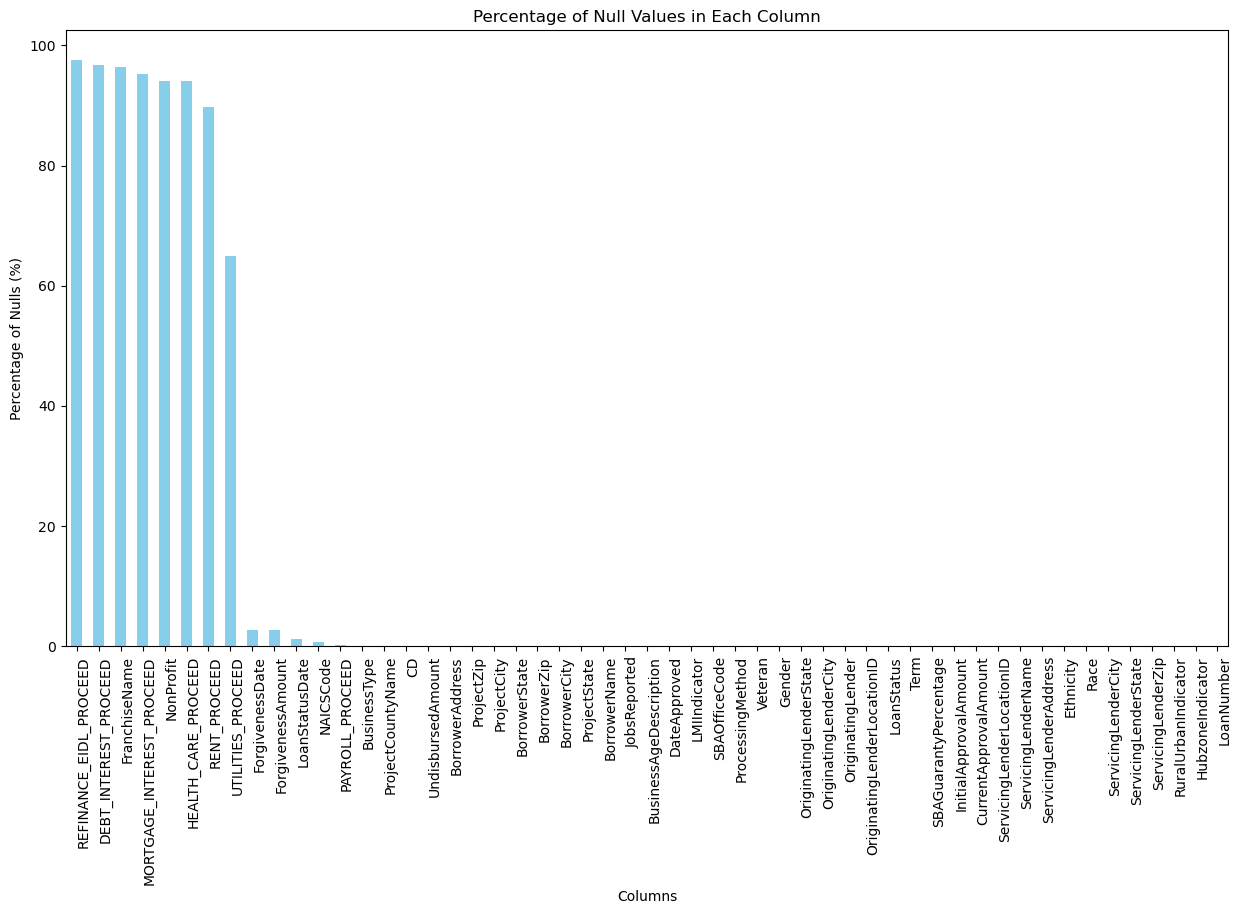

In [36]:
from matplotlib import pyplot as plt

# Calculate the percentage of null values for each column
null_counts = df.isnull().sum()
total_rows = len(df)
null_percentage = (null_counts / total_rows) * 100

# Sort
null_percentage = null_percentage.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(15, 8))  # Increase the figure size to fit 53 columns
ax = null_percentage.plot(kind='bar', color='skyblue')

# Shift the labels to the left
ax.set_xticklabels(ax.get_xticklabels(), ha='left', rotation=90)  # 'ha' is horizontal alignment

# Add title and labels
plt.title('Percentage of Null Values in Each Column')
plt.ylabel('Percentage of Nulls (%)')
plt.xlabel('Columns')

plt.show()